In [1]:
from data.dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

from models.lstm2 import Generator, Discriminator
from tools.viz import plot_columns, plot_epoch, plot_anomalies

from typing import Tuple

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('./data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        
        # Train params
        self.lr = 0.0002
        self.epochs = 500
        
        self.ngpu = 1
        self.model_out = Path('./models/train_hist/lstm/')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
opts = Options()

# Setup Dataset

In [2]:
dataset = MULTI_VP_Dataset(opts.data_path, method='multi')
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=opts.shuffle, 
                        num_workers=opts.nworkers, drop_last=opts.drop_last)

Inputs shape: torch.Size([11771, 3, 640])
Inputs head:
 tensor([[[0.0000, 0.5054, 0.5035,  ..., 0.6138, 0.6107, 0.6073],
         [0.9529, 0.9526, 0.9527,  ..., 0.9420, 0.9424, 0.9418],
         [0.3286, 0.3271, 0.3269,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.6247, 0.6232,  ..., 0.7131, 0.7101, 0.7092],
         [0.9550, 0.9546, 0.9547,  ..., 0.9555, 0.9558, 0.9552],
         [0.4021, 0.4003, 0.4034,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.7320, 0.7332,  ..., 0.6952, 0.6929, 0.6912],
         [0.9600, 0.9596, 0.9594,  ..., 0.9569, 0.9571, 0.9564],
         [0.4693, 0.4667, 0.4709,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.3908, 0.3914,  ..., 0.6718, 0.6692, 0.6681],
         [0.9518, 0.9515, 0.9514,  ..., 0.9605, 0.9604, 0.9598],
         [0.2556, 0.2542, 0.2547,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.6358, 0.6358,  ..., 0.6582, 0.6555, 0.6533],
         [0.9580, 0.9576, 0.9575,  ..., 0.9557, 0.9560, 0.9553],
         [0.4083, 0.4070, 

# Models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


In [4]:
netG = Generator(
    input_size=dataset.inputs.shape[2],
    hidden_size=128,
    output_size=dataset.inputs.shape[2],
    device=device
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[2],
    hidden_size=128,
    device=device
).to(device)

print(netG, netD)

Generator(
  (lstm0): LSTM(640, 128, batch_first=True)
  (lstm1): LSTM(128, 256, batch_first=True)
  (lstm2): LSTM(256, 512, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=640, bias=True)
    (1): Tanh()
  )
) Discriminator(
  (lstm): LSTM(640, 128, batch_first=True)
  (lstm1): LSTM(128, 256, batch_first=True)
  (lstm2): LSTM(256, 512, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


# Training

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

seq_len = dataset.inputs.shape[1]


In [12]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    # For each batch in the dataloader
    for i, (x, _filename) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real = x.to(device)
        
        b_size = real.size(0)
        label = torch.full((b_size, seq_len, 1), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output, _ = netD(real)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn_like(real, device=device)
        # Generate fake batch with G
        fake, _ = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output, _ = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output, _ = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opts.epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2),
                  end='\r', flush=True)

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
    
    # save best model so far
    if errD.item() + errG.item() < best_loss:
        best_loss = errD.item() + errG.item()
        torch.save(netG.state_dict(), opts.model_out / 'G.pth')
        torch.save(netD.state_dict(), opts.model_out / 'D.pth')
        
        if opts.train_plots:
            plot_epoch(fake.detach().cpu().numpy(), dataset.scaler,
                       opts.model_out / f'e{epoch}.png', f"Epoch {epoch} - Generated data",
                       scales={'B [G]':'symlog', 'alpha [deg]': 'linear'})
    

Starting Training Loop...


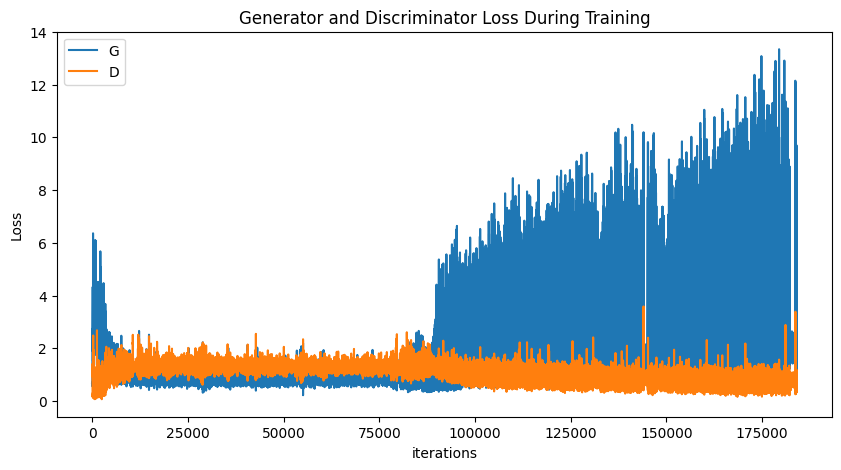

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Random Generated Inputs

In [5]:
# load best model
netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

<All keys matched successfully>

In [7]:
lines = []

# generate random samples
for i in range(100):
    noise = torch.randn((1, 3, 640), device=device)
    fake, _ = netG(noise)
    fake = fake.flatten(end_dim=1).detach().cpu().numpy()
    lines.append(fake)

lines = np.array([np.concatenate(values, axis=0) for values in lines])
lines.shape

fake_data = pd.DataFrame(lines)
inv_fake_data = dataset.scaler.inverse_transform(fake_data)
inv_fake_data = pd.DataFrame(inv_fake_data)

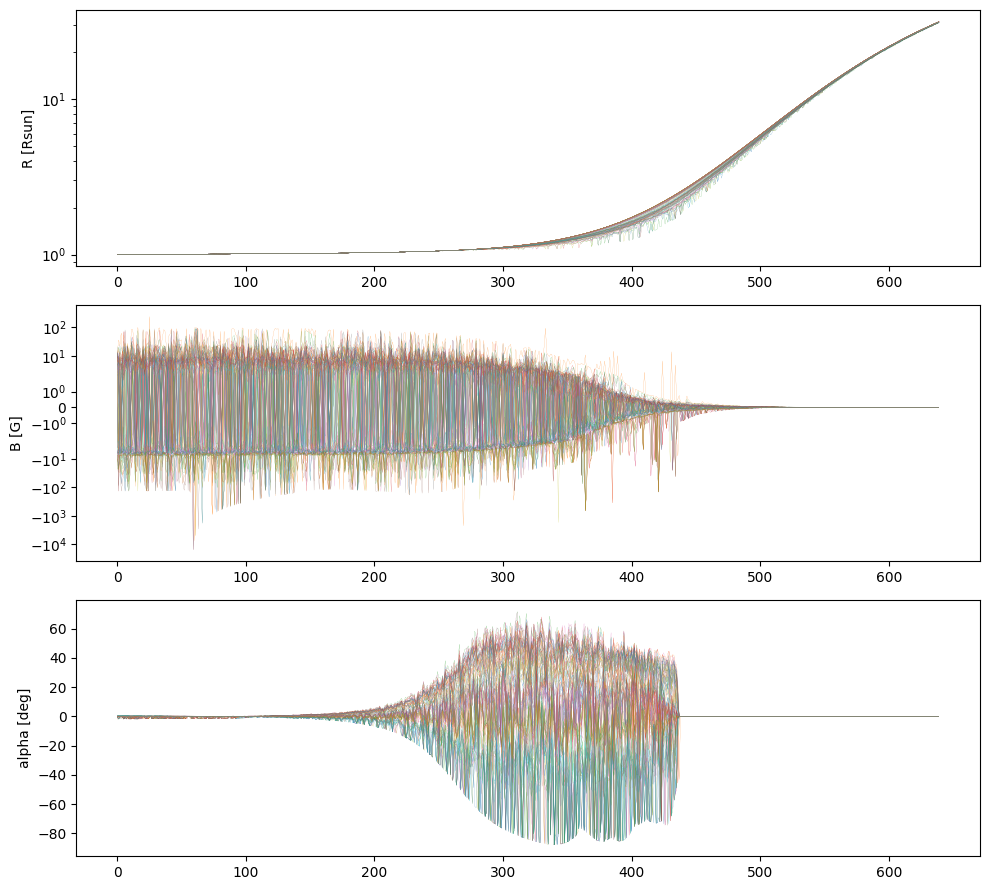

In [8]:
plot_columns(inv_fake_data, scales={'B [G]':'symlog', 'alpha [deg]': 'linear'})

# Anomaly Detection

In [5]:
# load best models
netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))
netD.load_state_dict(torch.load(opts.model_out / 'D.pth'))

netG.train = False
netD.train = False

test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=3)

## Discriminator Classification

In [6]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(test_dataloader):
    outputs, _ = netD(x.to(device))
    
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        class_avg = sample.mean()
        scores.append((filename, class_avg.item()))

In [7]:
# Parameters
d_class_thresh = 0.5

anomalies = [score for score in scores if score[1] < d_class_thresh]
print(f"Found {len(anomalies)} anomalies")


Found 1715 anomalies


### Plot anomalies

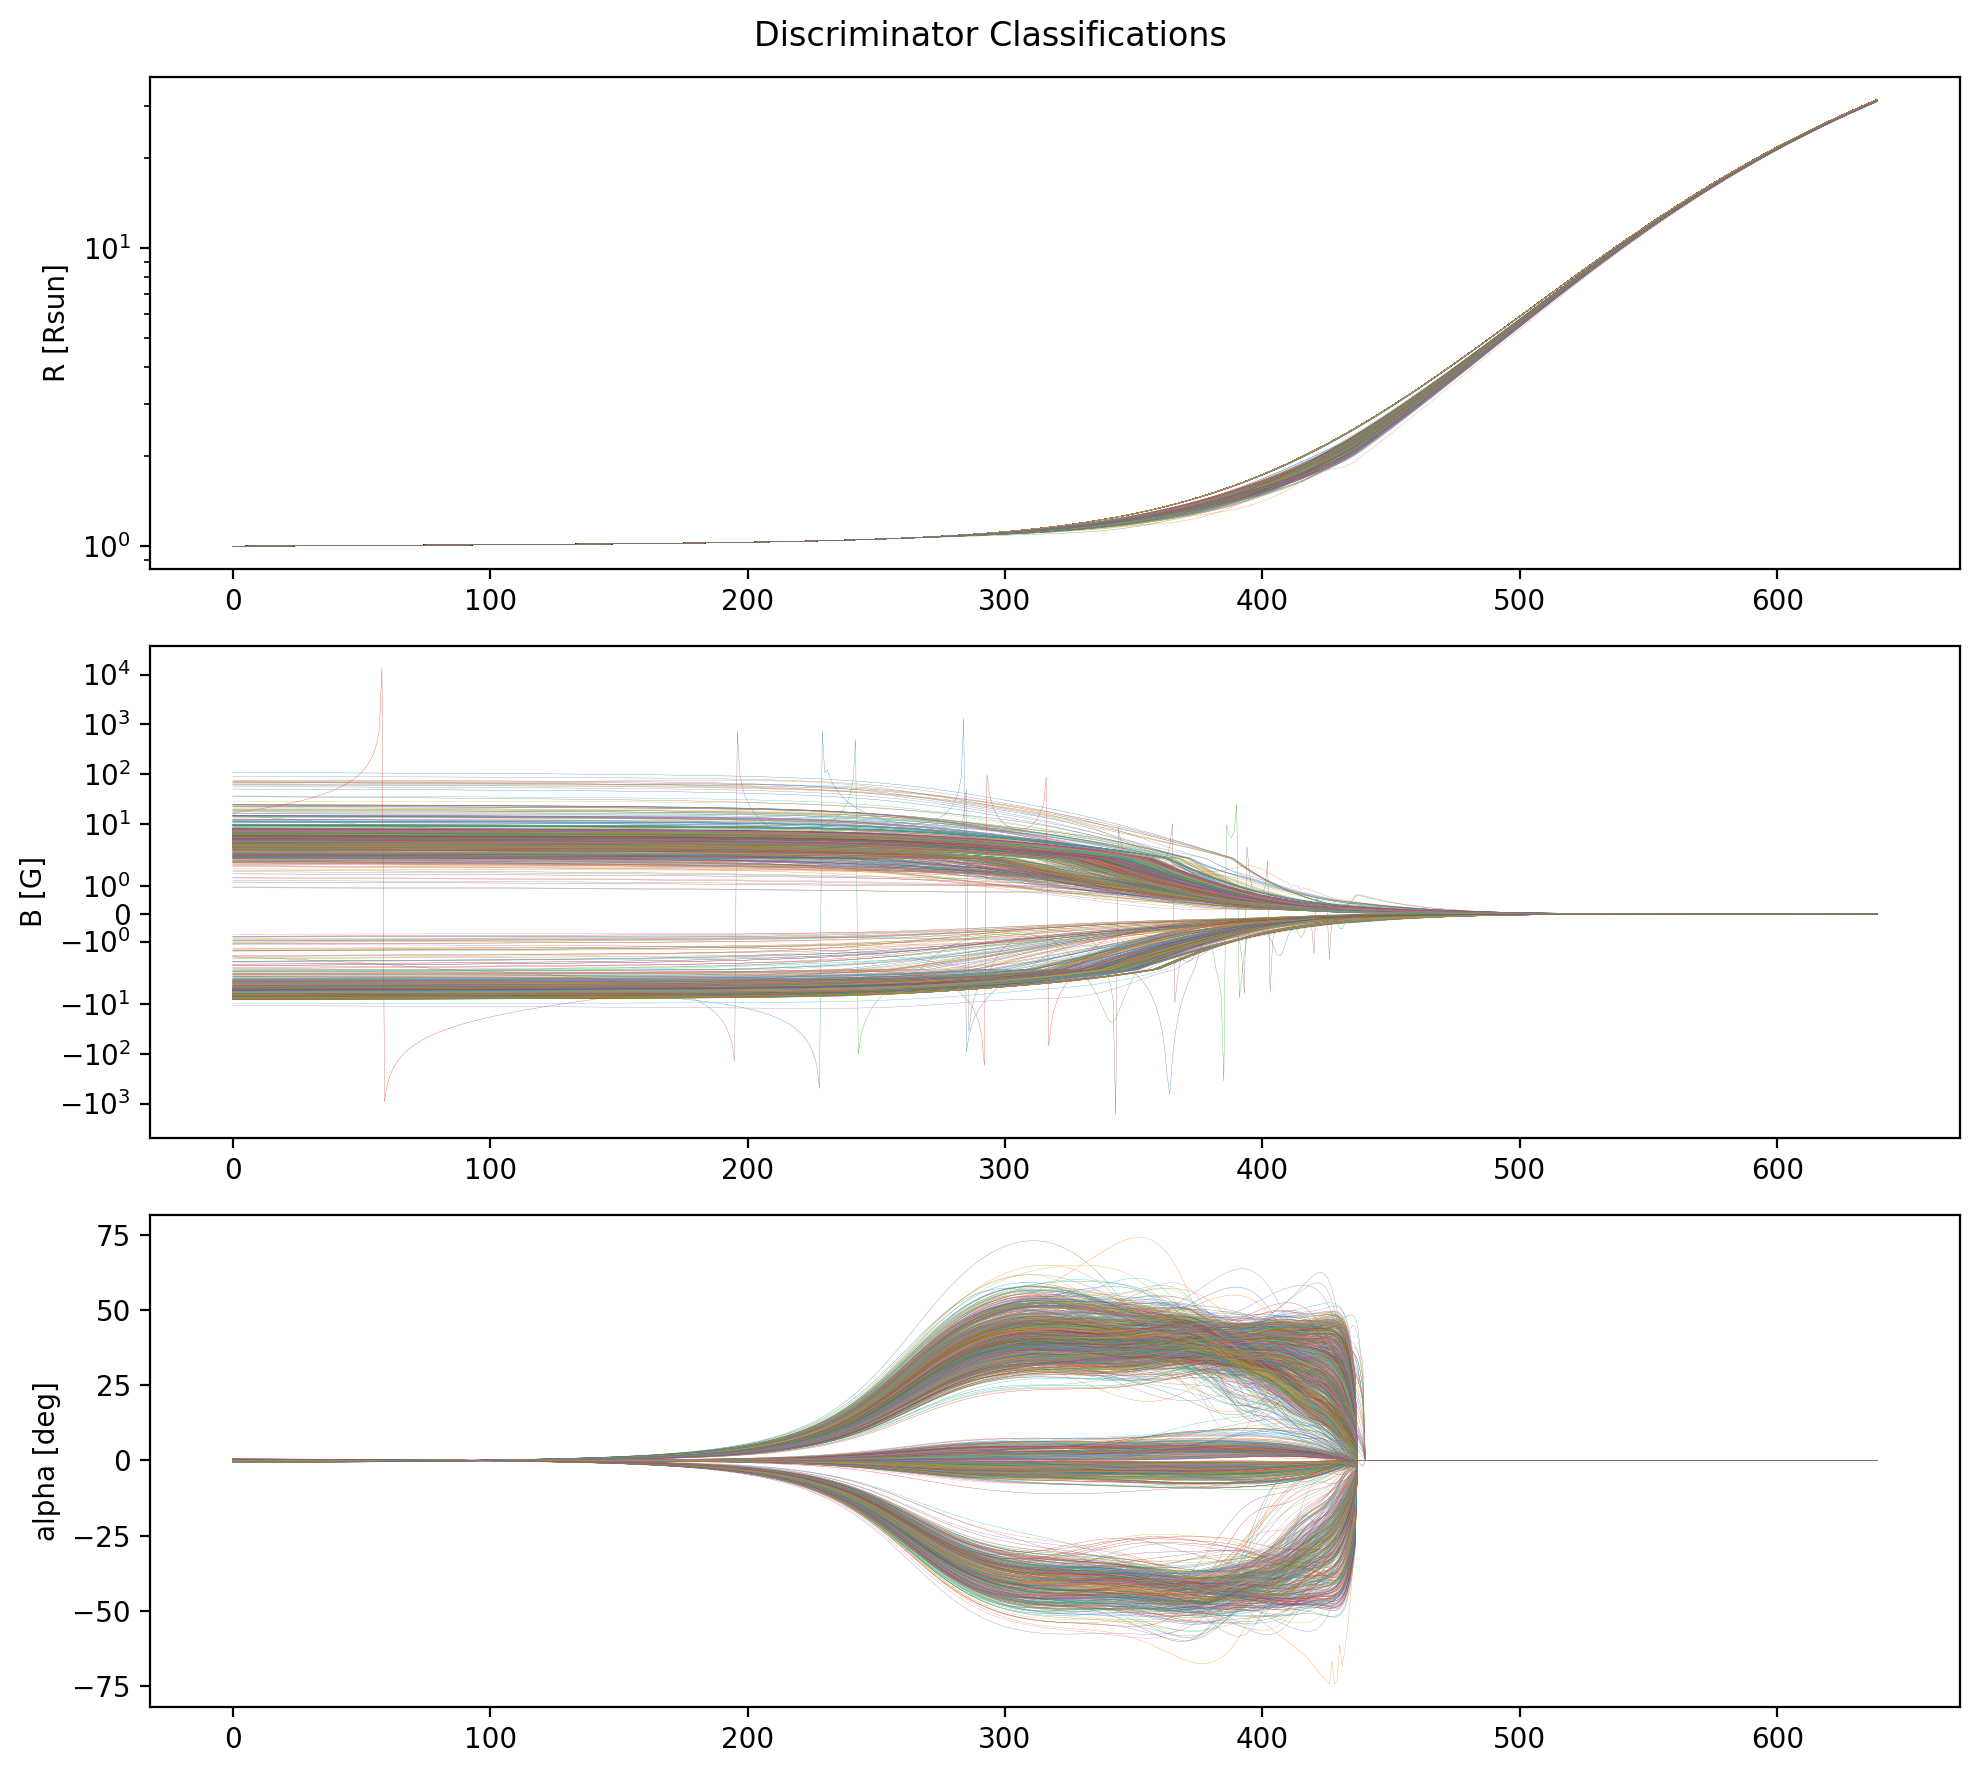

In [8]:
plot_anomalies(anomalies, dataloader, "Discriminator Classifications")
